In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import SimpleITK as sitk
import nibabel as nib
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

### Visualizar métricas

In [268]:
patch_id = 'Ingenio_RYC_00077_HE [x=60539,y=30595,w=540,h=540]'

base_path = os.path.join(os.path.expanduser('~'), 'projects', 'HoVerNet_INGENIO')

pred_inst_map_path = os.path.join(base_path, 'inferences', 'Inference_val_exp1_DMG', #Inference_val_exp1_DMG
                                  f'{patch_id}_image_instance_map.nii.gz')
pred_type_map_path = os.path.join(base_path, 'inferences', 'Inference_val_exp1_DMG', # InferenceValidexp1
                                  f'{patch_id}_image_type_map.nii.gz')

gt_inst_map_path = os.path.join(base_path, 'data', 'Valid',
                                  f'{patch_id}_inst_map.npy')
gt_type_map_path = os.path.join(base_path, 'data', 'Valid',
                                  f'{patch_id}_type_map.npy')

In [269]:
# pred_inst_map = nib.load(pred_inst_map_path).get_fdata()
# pred_type_map = nib.load(pred_type_map_path).get_fdata()

pred_inst_map = sitk.GetArrayFromImage(sitk.ReadImage(pred_inst_map_path))
pred_type_map = sitk.GetArrayFromImage(sitk.ReadImage(pred_type_map_path))

gt_inst_map = np.load(gt_inst_map_path)
gt_type_map = np.load(gt_type_map_path)

In [270]:
pred_inst_map.shape, pred_type_map.shape, gt_inst_map.shape, gt_type_map.shape

((540, 540), (540, 540), (540, 540, 1), (540, 540, 1))

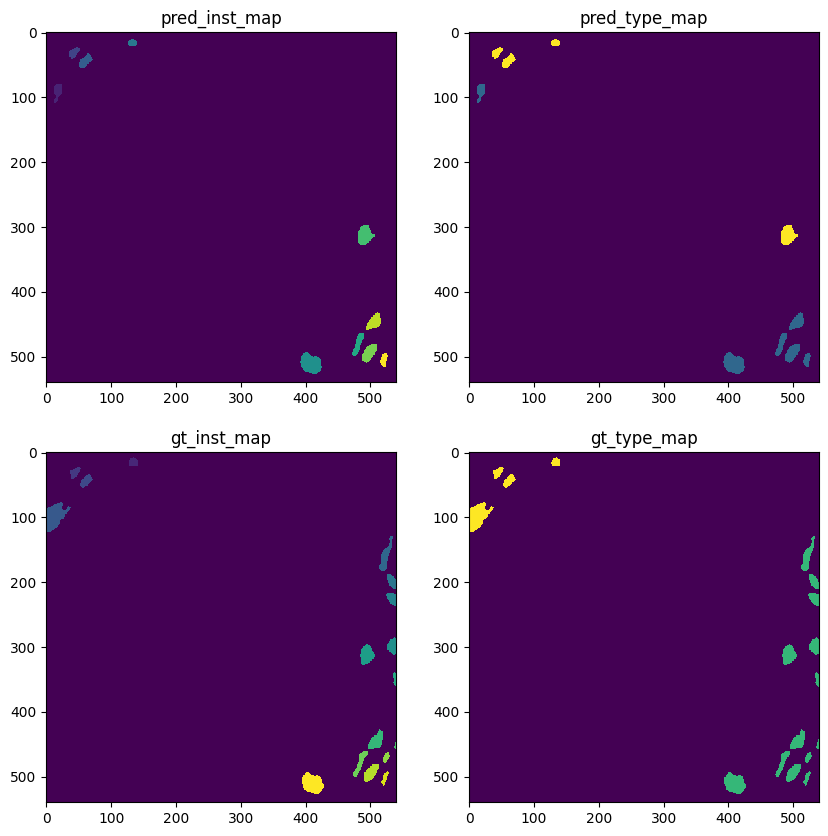

In [272]:
# plot the 4 maps in a grid of 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(pred_inst_map, interpolation='none')
axs[0, 0].set_title('pred_inst_map')
axs[0, 1].imshow(pred_type_map, interpolation='none')
axs[0, 1].set_title('pred_type_map')
axs[1, 0].imshow(gt_inst_map, interpolation='none')
axs[1, 0].set_title('gt_inst_map')
axs[1, 1].imshow(gt_type_map, interpolation='none')
axs[1, 1].set_title('gt_type_map')
plt.show()

### Métrica PQ ejemplo

In [7]:
from monai.metrics.panoptic_quality import PanopticQualityMetric, \
    compute_panoptic_quality
import torch

In [185]:
pq_metric = PanopticQualityMetric(
    num_classes=3, 
    metric_name=('pq','sq', 'rq'),
    reduction='none',
)

In [186]:
y = np.stack((np.expand_dims(gt_inst_map[...,0], axis=0), 
              np.expand_dims(gt_type_map[...,0], axis=0)), axis=1)
y = torch.tensor(y, dtype=torch.int32)

y_pred = np.stack((np.expand_dims(pred_inst_map, axis=0), 
                   np.expand_dims(pred_type_map, axis=0)), axis=1)
y_pred = torch.tensor(y_pred, dtype=torch.int32)

pq_metric(y_pred, y)

tensor([[[27.0000, 16.0000, 48.0000, 19.2958],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [16.0000, 27.0000, 21.0000, 12.1394]]])

In [188]:
pq_value, sq_value, rq_value = pq_metric.aggregate()

In [191]:
rq_value

tensor([[0.4576, 0.0000, 0.4000]])

### PASO 3. Sacar métrica PQ en todos los parches de validación

In [57]:
import regex as re

In [386]:
pq_metric_mean = PanopticQualityMetric(
    num_classes=3, 
    metric_name=('pq','sq', 'rq'),
    reduction='mean',
    match_iou_threshold=0.5,
    smooth_numerator=1e-10
)

pq_metric_class = PanopticQualityMetric(
    num_classes=3, 
    metric_name=('pq','sq', 'rq'),
    reduction='none',
    match_iou_threshold=0.5,
    smooth_numerator=1e-10
)

In [387]:
pq_values_mean, sq_values_mean, rq_values_mean = [], [], []
pq_values_classes, sq_values_classes, rq_values_classes = [], [], []

for i in os.listdir(os.path.join(base_path, 'inferences', 'Inference_val_exp1_DMG'))[:16]:

    patch_pattern = re.search(r'(.*)_image_instance_map.nii.gz', i)

    if patch_id := patch_pattern:
        patch_id = patch_id.group(1)
    else:
        continue

    print(patch_id)
    
    pred_inst_map_path = os.path.join(base_path, 'inferences', 'Inference_val_exp1_DMG', #Inference_val_exp1_DMG
                                    f'{patch_id}_image_instance_map.nii.gz')
    pred_type_map_path = os.path.join(base_path, 'inferences', 'Inference_val_exp1_DMG', # InferenceValidexp1
                                    f'{patch_id}_image_type_map.nii.gz')

    gt_inst_map_path = os.path.join(base_path, 'data', 'Valid',
                                    f'{patch_id}_inst_map.npy')
    gt_type_map_path = os.path.join(base_path, 'data', 'Valid',
                                    f'{patch_id}_type_map.npy')

    pred_inst_map = sitk.GetArrayFromImage(sitk.ReadImage(pred_inst_map_path))
    pred_type_map = sitk.GetArrayFromImage(sitk.ReadImage(pred_type_map_path))

    gt_inst_map = np.load(gt_inst_map_path)
    gt_type_map = np.load(gt_type_map_path)

    y = np.stack((np.expand_dims(gt_inst_map[...,0], axis=0), 
                np.expand_dims(gt_type_map[...,0], axis=0)), axis=1)
    y = torch.tensor(y, dtype=torch.int32)

    y_pred = np.stack((np.expand_dims(pred_inst_map, axis=0), 
                    np.expand_dims(pred_type_map, axis=0)), axis=1)
    y_pred = torch.tensor(y_pred, dtype=torch.int32)

    # pq_metric_class(y_pred, y)
    pq_metric_mean(y_pred, y)

    pq_value, sq_value, rq_value = pq_metric_mean.aggregate()
    pq_metric_mean.reset()

    pq_values_mean.append(pq_value)
    sq_values_mean.append(sq_value)
    rq_values_mean.append(rq_value)

    print(pq_value, sq_value, rq_value)


    print(pq_metric_class(y_pred, y))

    pq_value, sq_value, rq_value = pq_metric_class.aggregate()
    pq_metric_class.reset()

    pq_values_classes.append(pq_value)
    sq_values_classes.append(sq_value)
    rq_values_classes.append(rq_value)


    print(pq_value, sq_value, rq_value, '\n')


Ingenio_RYC_00077_HE [x=60539,y=30595,w=540,h=540]
TP 0
tensor(0.1649) tensor(0.7696) tensor(0.2143)
tensor([[[ 0.0000,  6.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, 13.0000,  0.0000],
         [ 3.0000,  1.0000,  2.0000,  2.3088]]])
TP 2
tensor([[3.3333e-11, 1.5385e-11, 5.1306e-01]]) tensor([[0.0000, 0.0000, 0.7696]]) tensor([[3.3333e-11, 1.5385e-11, 6.6667e-01]]) 

Ingenio_RYC_00045_HE [x=59051,y=6286,w=540,h=540]
TP 0
tensor(1.) tensor(0.) tensor(1.)
tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])
TP 2
tensor([[1., 1., 1.]]) tensor([[0., 0., 0.]]) tensor([[1., 1., 1.]]) 

Ingenio_RYC_00077_HE [x=53019,y=21195,w=540,h=540]
TP 0
tensor(0.0295) tensor(0.6934) tensor(0.0426)
tensor([[[ 0.0000,  8.0000,  8.0000,  0.0000],
         [ 0.0000,  0.0000,  5.0000,  0.0000],
         [ 1.0000, 20.0000,  4.0000,  0.6934]]])
TP 2
tensor([[1.2500e-11, 4.0000e-11, 5.3339e-02]]) tensor([[0.0000, 0.0000, 0.6934]]) tensor([[1.2500e-11, 4.0000e-11, 7.6923e-0

In [388]:
np.mean(pq_values_mean)

0.30073193

In [389]:
sq_values_mean

[tensor(0.7696),
 tensor(0.),
 tensor(0.6934),
 tensor(0.7248),
 tensor(0.7408),
 tensor(0.7847),
 tensor(0.)]

In [390]:
np.mean(sq_values_mean)

0.5304582

In [391]:
np.mean(rq_values_mean)

0.35047078

In [392]:
# array([[0.14285715, 0.14285715, 0.39080366]], dtype=float32)

In [393]:
np.array(pq_values_classes).mean(axis=0)

array([[0.14285715, 0.14285715, 0.39080366]], dtype=float32)

In [394]:
np.array(sq_values_classes).mean(axis=0)

array([[0.       , 0.       , 0.5304582]], dtype=float32)

In [395]:
np.array(rq_values_classes).mean(axis=0)

array([[0.14285715, 0.14285715, 0.469997  ]], dtype=float32)

### PASO 1. Convertir parches .npy en parches .jpg a color

In [85]:
for file in os.listdir(os.path.join(base_path, 'data', 'Valid')):
    if file.endswith('_image.npy'):
        print(file)
        img = np.load(os.path.join(base_path, 'data', 'Valid', file))
        img = Image.fromarray(img)
        img.save(os.path.join(base_path, 'data', 'Valid_jpg_NEW', file.replace('npy', 'jpg')))

Ingenio_RYC_00075_HE.tiff [x=89664,y=38200,w=540,h=540]_image.npy
Ingenio_RYC_00103_HE [x=93686,y=38364,w=540,h=540]_image.npy
Ingenio_RYC_00103_HE [x=95190,y=39116,w=540,h=540]_image.npy
Ingenio_RYC_00075_HE.tiff [x=87784,y=40456,w=540,h=540]_image.npy
Ingenio_RYC_00096_HE.tiff [x=71792,y=15403,w=540,h=540]_image.npy
Ingenio_RYC_00075_HE.tiff [x=90792,y=38576,w=540,h=540]_image.npy
Ingenio_RYC_00075_HE.tiff [x=91544,y=39328,w=540,h=540]_image.npy
Ingenio_RYC_00077_HE [x=60539,y=32475,w=540,h=540]_image.npy
Ingenio_RYC_00077_HE [x=60915,y=33227,w=540,h=540]_image.npy
Ingenio_RYC_00075_HE.tiff [x=88912,y=39328,w=540,h=540]_image.npy
Ingenio_RYC_00077_HE [x=54523,y=21571,w=540,h=540]_image.npy
Ingenio_RYC_00103_HE [x=92558,y=33476,w=540,h=540]_image.npy
Ingenio_RYC_00101_HE [x=93553,y=4491,w=540,h=540]_image.npy
Ingenio_RYC_00100_HE [x=32770,y=15431,w=540,h=540]_image.npy
Ingenio_RYC_00077_HE [x=60915,y=30971,w=540,h=540]_image.npy
Ingenio_RYC_00045_HE [x=57923,y=5910,w=540,h=540]_image.

### PASO 2. Ejecutar inference.py para sacar las inferencias de validación